# Compare IBM's influence on individuals inside/outside IBM
Author: Daheng Wang  
Last modified: 2017-06-16

# Roadmap
1. Check the distribution of user_popularity levels of M1 IBM users
2. Check the distribution of followers_engagement levels of M1 IBM users
3. Simple influence by different (user_popularity, followers_engagement) combinations
4. Compound inlfuence by different (user_popularity, followers_engagement) combinations

# Steps

In [1]:
"""
Initialization
"""

'''
Data analysis modules: pandas, matplotlib, numpy, and etc.
'''
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # render double resolution plot output for Retina screens 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

'''
Standard modules, MongoDB modules
'''
import os, sys, json, datetime, pickle, multiprocessing, logging
from pprint import pprint

import pymongo
from pymongo import IndexModel, ASCENDING, DESCENDING

'''
Custom tool modules
'''
import mongodb  # module for setting up connection with (local) MongoDB database
import multiprocessing_workers  # module for splitting workloads between processes
import utilities  # module for various custom utility functions
from config import * # import all global configuration variables

'''
Misc
'''
NB_NAME = '20170615-compare_influence_inside_outside_2'

## Prepare data

In [2]:
'''
Load pickle data
'''
df = pd.read_pickle(IBM_INFLUENCE_PKL)

'''
Remove rows with NaN of fo_2
'''
df = df.dropna(subset=['fo_2'], how='any')

'''
Clean rows with native_n < all_n
'''
df = df.drop(df['native_n'] < df['all_n'])

'''
Clean other NaNs
'''
df = df.fillna(0)

'''
Compute nubmer of non-IBM followers
'''
df = df.assign(fo_nonibm = df['fo_2'] - df['fo_ibm'])

'''
Add new column for quartile labels of fo_2
'''
df['fo_2_quar'] = pd.qcut(df['fo_2'], 4, labels=False)

In [3]:
'''
Separate influence on inside/outside users
'''
df_in = df[df['ibm_n'] > 0]
df_out = df[df['nonibm_n'] > 0]

In [4]:
df.describe()

,uid,fo,all_n,all_srt,ibm_n,ibm_srt,nonibm_n,nonibm_srt,fo_2,fo_ibm,native_n,fo_nonibm,fo_2_quar
count,3.708000e+03,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000
mean,5.060382e+16,2086.938781,7.495955,35.831446,3.880529,11.131607,6.029935,24.699838,2103.889428,194.117584,19.926645,1909.771845,1.498382
std,1.919076e+17,10348.294746,24.609970,359.441014,17.151148,114.842189,22.060280,251.072907,10405.718706,640.664591,56.686660,9915.959737,1.119630
min,1.142600e+04,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1.000000,1.000000,0.000000
25%,5.874478e+07,159.750000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,167.000000,26.000000,2.000000,123.000000,0.000000
50%,3.700978e+08,403.000000,2.000000,4.000000,1.000000,1.000000,1.000000,2.000000,415.500000,69.000000,5.000000,317.000000,1.500000
75%,2.204183e+09,1140.250000,5.000000,10.000000,2.000000,3.000000,4.000000,6.000000,1167.250000,165.000000,17.000000,991.000000,2.250000
max,8.623589e+17,360556.000000,428.000000,14497.000000,333.000000,4877.000000,426.000000,9620.000000,362337.000000,16223.000000,1330.000000,346114.000000,3.000000


In [6]:
df[df['fo_ibm'] == 0]

,uid,fo,all_n,all_srt,ibm_n,ibm_srt,nonibm_n,nonibm_srt,fo_2,fo_ibm,native_n,fo_nonibm,fo_2_quar
52,104523978,42,2,4,0.0,0.0,2.0,4.0,38.0,0.0,6,38.0,0
383,2687470626,49,1,4,0.0,0.0,1.0,4.0,49.0,0.0,1,49.0,0
429,120486568,94,1,2,0.0,0.0,1.0,2.0,91.0,0.0,1,91.0,0
520,100685757,137,4,42,0.0,0.0,4.0,42.0,137.0,0.0,3,137.0,0
564,260889714,25,1,3,1.0,1.0,1.0,2.0,24.0,0.0,2,24.0,0
568,846720334699081730,3,1,1,0.0,0.0,1.0,1.0,5.0,0.0,9,5.0,0
576,797073166296346625,283,1,3,0.0,0.0,1.0,3.0,277.0,0.0,1,277.0,1
617,795512917831524352,1,1,2,0.0,0.0,1.0,2.0,3.0,0.0,1,3.0,0
658,3350817892,35,3,3,0.0,0.0,3.0,3.0,69.0,0.0,11,69.0,0
679,1350755520,43,4,4,0.0,0.0,4.0,4.0,43.0,0.0,21,43.0,0


In [6]:
# '''
# DISPLAY
# '''
# df_tmp = df[['fo_2', 'fo_ibm', 'fo_nonibm']].copy()
# display_names = {'fo_2': 'All Followers',
#                 'fo_ibm': 'IBM Followers',
#                 'fo_nonibm': 'non-IBM Followers'}
# df_tmp = df_tmp.rename(columns=display_names)
# df_tmp.describe()

,All Followers,IBM Followers,non-IBM Followers
count,3708.000000,3708.000000,3708.000000
mean,2103.889428,194.117584,1909.771845
std,10405.718706,640.664591,9915.959737
min,2.000000,0.000000,1.000000
25%,167.000000,26.000000,123.000000
50%,415.500000,69.000000,317.000000
75%,1167.250000,165.000000,991.000000
max,362337.000000,16223.000000,346114.000000


In [7]:
# df_tmp.corr()

,All Followers,IBM Followers,non-IBM Followers
All Followers,1.000000,0.777249,0.999173
IBM Followers,0.777249,1.000000,0.751028
non-IBM Followers,0.999173,0.751028,1.000000


In [6]:
'''
Compute simple influence on all/inside/outside users
'''
# simple influence to all users
all_norm_s = df['fo_2'] * df['native_n']
all_simple_inf = df['all_srt'] / all_norm_s

# simple influence to IBM users (inside)
in_norm_s = df['fo_ibm'] * df['native_n']
in_norm_s = in_norm_s.replace(to_replace=0, value=1) # clean 0 values since its denominator
in_simple_inf = df['ibm_srt'] / in_norm_s

# simple influence to non-IBM users (outside)
out_norm_s = df['fo_nonibm'] * df['native_n']
out_simple_inf = df['nonibm_srt'] / out_norm_s

# limit the minimum influence value
min_inf = 1e-7
all_simple_inf[all_simple_inf < min_inf] = min_inf
in_simple_inf[in_simple_inf < min_inf] = min_inf
out_simple_inf[out_simple_inf < min_inf] = min_inf

df = df.assign(all_simple_inf=all_simple_inf)
df = df.assign(in_simple_inf=in_simple_inf)
df = df.assign(out_simple_inf=out_simple_inf)


'''
Compute compound influence on all/inside/outside users
'''
# compound influence to all users
all_arc = df['all_srt'] / df['native_n']
all_compound_inf = all_arc * np.log(df['fo_2'])

# compound influence to IBM users (inside)
ibm_arc = df['ibm_srt'] / df['native_n']
cleaned_ibm_fo = df['fo_ibm'].replace(to_replace=0, value=1) # clean 0 values since its denominator
in_compound_inf = ibm_arc * np.log(cleaned_ibm_fo)

# compound influence to non-IBM users (outside)
nonibm_arc = df['nonibm_srt'] / df['native_n']
out_compound_inf = nonibm_arc * np.log(df['fo_nonibm'])

# limit the minimum influence value
min_inf = 1e-2
all_compound_inf[all_compound_inf < min_inf] = min_inf
in_compound_inf[in_compound_inf < min_inf] = min_inf
out_compound_inf[out_compound_inf < min_inf] = min_inf

df = df.assign(all_compound_inf=all_compound_inf)
df = df.assign(in_compound_inf=in_compound_inf)
df = df.assign(out_compound_inf=out_compound_inf)

In [7]:
df.describe()

,uid,fo,all_n,all_srt,ibm_n,ibm_srt,nonibm_n,nonibm_srt,fo_2,fo_ibm,native_n,fo_nonibm,fo_2_quar,all_simple_inf,in_simple_inf,out_simple_inf,all_compound_inf,in_compound_inf,out_compound_inf
count,3.708000e+03,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3.708000e+03,3.708000e+03,3.708000e+03,3708.000000,3708.000000,3708.000000
mean,5.060382e+16,2086.938781,7.495955,35.831446,3.880529,11.131607,6.029935,24.699838,2103.889428,194.117584,19.926645,1909.771845,1.498382,7.952375e-03,2.398495e-02,7.439521e-03,10.361020,2.723863,6.535513
std,1.919076e+17,10348.294746,24.609970,359.441014,17.151148,114.842189,22.060280,251.072907,10405.718706,640.664591,56.686660,9915.959737,1.119630,4.479740e-02,6.644348e-01,4.677205e-02,33.335735,8.289360,26.598623
min,1.142600e+04,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1.000000,1.000000,0.000000,7.006702e-07,1.000000e-07,1.000000e-07,0.064984,0.010000,0.010000
25%,5.874478e+07,159.750000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,167.000000,26.000000,2.000000,123.000000,0.000000,4.987603e-04,1.000000e-07,1.577005e-04,2.017726,0.010000,0.793314
50%,3.700978e+08,403.000000,2.000000,4.000000,1.000000,1.000000,1.000000,2.000000,415.500000,69.000000,5.000000,317.000000,1.500000,1.608903e-03,1.098901e-03,9.456265e-04,4.481139,0.604262,2.446853
75%,2.204183e+09,1140.250000,5.000000,10.000000,2.000000,3.000000,4.000000,6.000000,1167.250000,165.000000,17.000000,991.000000,2.250000,5.144198e-03,6.756757e-03,3.703704e-03,9.100423,2.707234,5.737077
max,8.623589e+17,360556.000000,428.000000,14497.000000,333.000000,4877.000000,426.000000,9620.000000,362337.000000,16223.000000,1330.000000,346114.000000,3.000000,1.791667e+00,4.025000e+01,2.000000e+00,1052.376124,239.817227,795.789550


## Check the distribution of user_popularity levels of M1 IBM users
The popularity level of a user is represented by his followers_count.

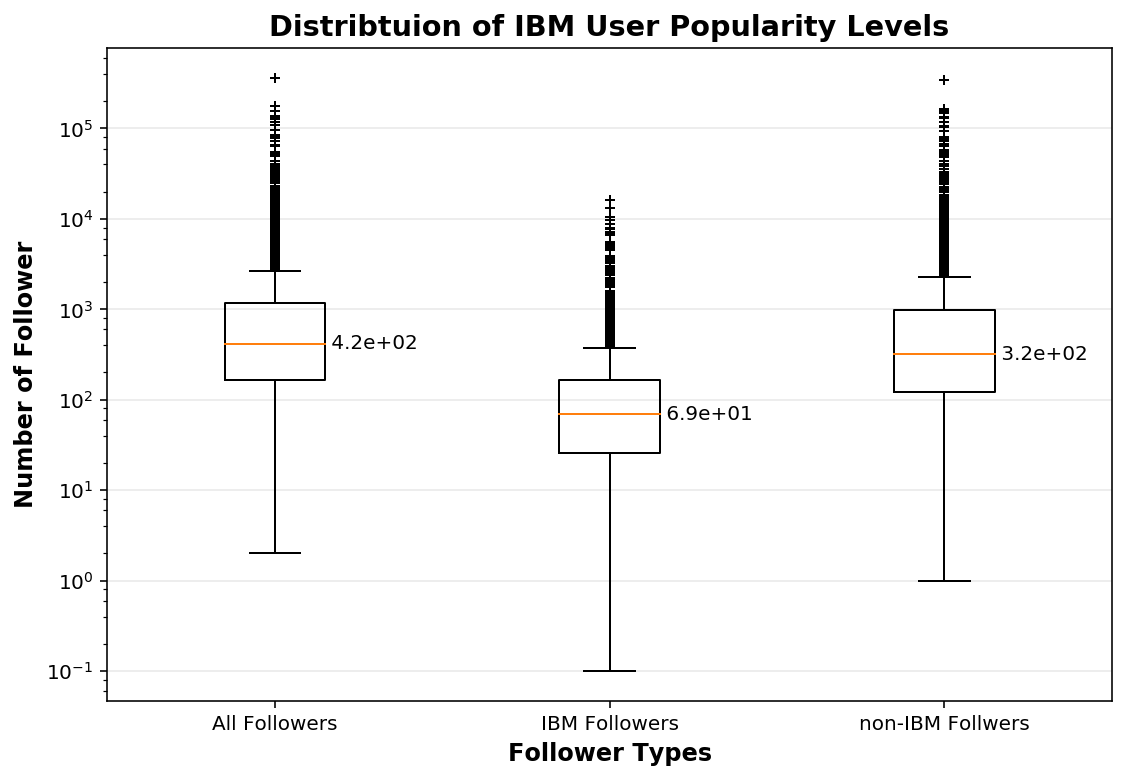

In [8]:
"""
Boxplot of total/IBM/non-IBM followers
"""
m1_ibm_popularity_levels_fig = os.path.join(FIG_DIR, 'm1_ibm_popularity_levels.png')
if 1 == 1:
    '''
    Prepare data
    '''
    followers_all = df['fo_2']
    followers_ibm = df['fo_ibm']
    followers_nonibm = df['fo_nonibm']
    
    # limit the minimal popularity level (clear 0 'fo_ibm' to avoid err in log scale)
    min_popularity_cond = (df['fo_ibm'] == 0)
    df.loc[min_popularity_cond, 'fo_ibm'] = 0.1
    
        
    data = [followers_all, followers_ibm, followers_nonibm]
    
    '''
    Plot
    '''
    fig, ax = plt.subplots(figsize=(9, 6))
    
    bp = plt.boxplot(data, notch=False, sym='k+', vert=True)
    plt.setp(bp['boxes'], color='black')
    plt.setp(bp['whiskers'], color='black')
    plt.setp(bp['fliers'], color='red', marker='+', markersize=5)
    
    title_fontdict = {'weight': 'bold', 'size': 'x-large'}
    ax.set_title("Distribtuion of IBM User Popularity Levels", fontdict=title_fontdict)
    
    label_fontdict = {'weight': 'bold', 'size': 'large'}
    ax.set_xlabel('Follower Types', fontdict=label_fontdict)
    ax.set_ylabel('Number of Follower', fontdict=label_fontdict)
    ax.set_xticklabels(['All Followers', 'IBM Followers', 'non-IBM Follwers'])
    ax.set_yscale('log')
    
    # add a horizontal grid to the plot, but make it very light in color
    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
    ax.set_axisbelow(True)
    
    # add median value text to the median line
    for line in bp['medians']:
        # get position data for median line
        x, y = line.get_xydata()[1] # right point of median line
        # overlay median value
        ax.text(x, y, '{:8.1e}'.format(y), horizontalalignment='left', verticalalignment='center')
    
    '''
    Save figure
    '''
    plt.savefig(m1_ibm_popularity_levels_fig, dpi=200)

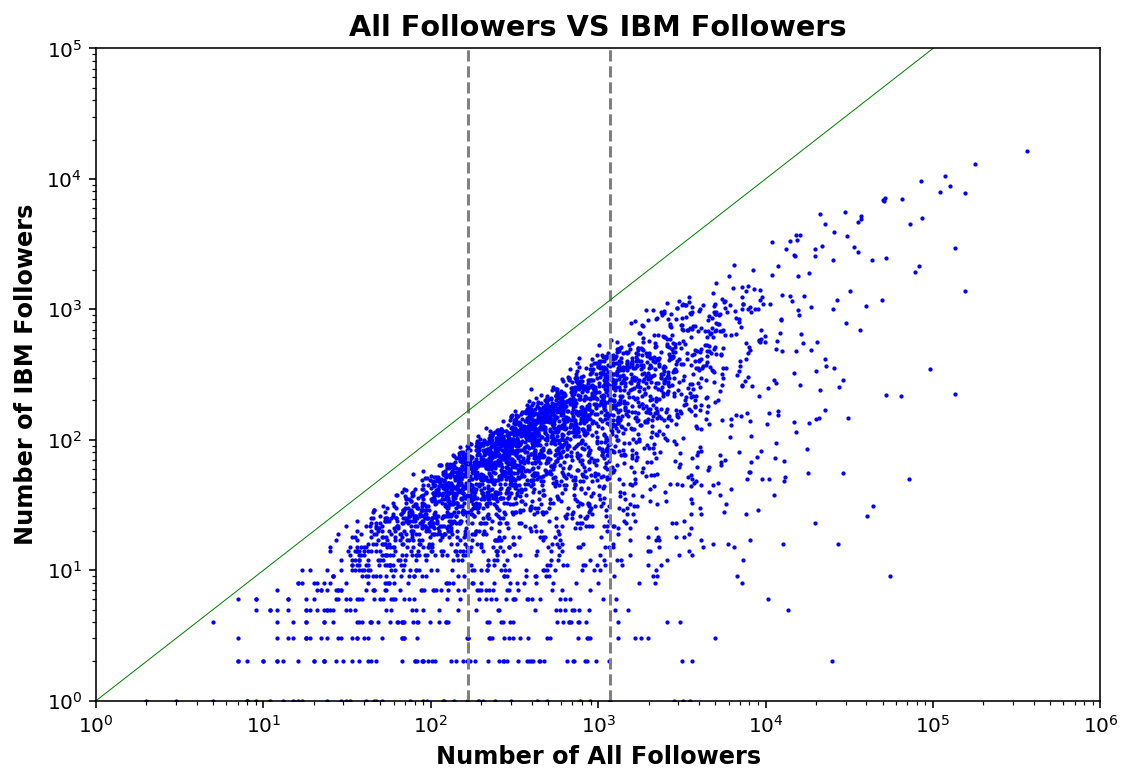

In [23]:
"""
Scatter plot of total/IBM/non-IBM followers
"""
m1_ibm_popularity_levels_2_fig = os.path.join(FIG_DIR, 'm1_ibm_popularity_levels_2.png')
if 1 == 1:
    '''
    Prepare data
    '''
    followers_all = df['fo_2']
    followers_ibm = df['fo_ibm']
    
    #followers_all_rank = df['fo_2'].rank(method='average', ascending=False)
  
    '''
    Plot
    '''
    fig, ax = plt.subplots(figsize=(9, 6))
    
    scp = plt.scatter(followers_all, followers_ibm, s=5, c='b', marker='.')
    
    # add two vertical lines for Q1 and Q3
    fo_2_q1_value = df.quantile(0.25)['fo_2']
    fo_2_q3_value = df.quantile(0.75)['fo_2']
    ax.axvline(x=fo_2_q1_value, c='grey', ls='--')
    ax.axvline(x=fo_2_q3_value, c='grey', ls='--')
    
    # add y=x line for upper bound of IBM followers
    plt.plot([1, 1e5], [1, 1e5], c='g', ls='-', lw=0.5)
    
    title_fontdict = {'weight': 'bold', 'size': 'x-large'}
    ax.set_title('All Followers VS IBM Followers', fontdict=title_fontdict)
    
    label_fontdict = {'weight': 'bold', 'size': 'large'}
    ax.set_xlabel('Number of All Followers', fontdict=label_fontdict)
    ax.set_ylabel('Number of IBM Followers', fontdict=label_fontdict)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim([1,1e6])
    ax.set_ylim([1,1e5])
    
    
    '''
    Save figure
    '''
    plt.savefig(m1_ibm_popularity_levels_2_fig, dpi=200)

In [9]:
"""
Check Pearson Correlation between all/IBM popularity levels
"""
df[['fo_2', 'fo_ibm', 'fo_nonibm']].corr()

,fo_2,fo_ibm,fo_nonibm
fo_2,1.000000,0.777249,0.999173
fo_ibm,0.777249,1.000000,0.751029
fo_nonibm,0.999173,0.751029,1.000000


In [10]:
np.corrcoef(np.log(df['fo_2']), np.log(df['fo_ibm']))

array([[ 1.        ,  0.67488236],
       [ 0.67488236,  1.        ]])

In [11]:
from scipy.stats.stats import pearsonr   

pearsonr(np.log(df['fo_2']), np.log(df['fo_ibm']))

(0.67488235697404908, 0.0)

In [12]:
df_tmp = pd.DataFrame({'log_fo': np.log(df['fo_2']), 'log_fo_ibm': np.log(df['fo_ibm']), 'log_fo_nonibm': np.log(df['fo_nonibm'])})
df_tmp.corr()

,log_fo,log_fo_ibm,log_fo_nonibm
log_fo,1.000000,0.674882,0.993896
log_fo_ibm,0.674882,1.000000,0.611627
log_fo_nonibm,0.993896,0.611627,1.000000


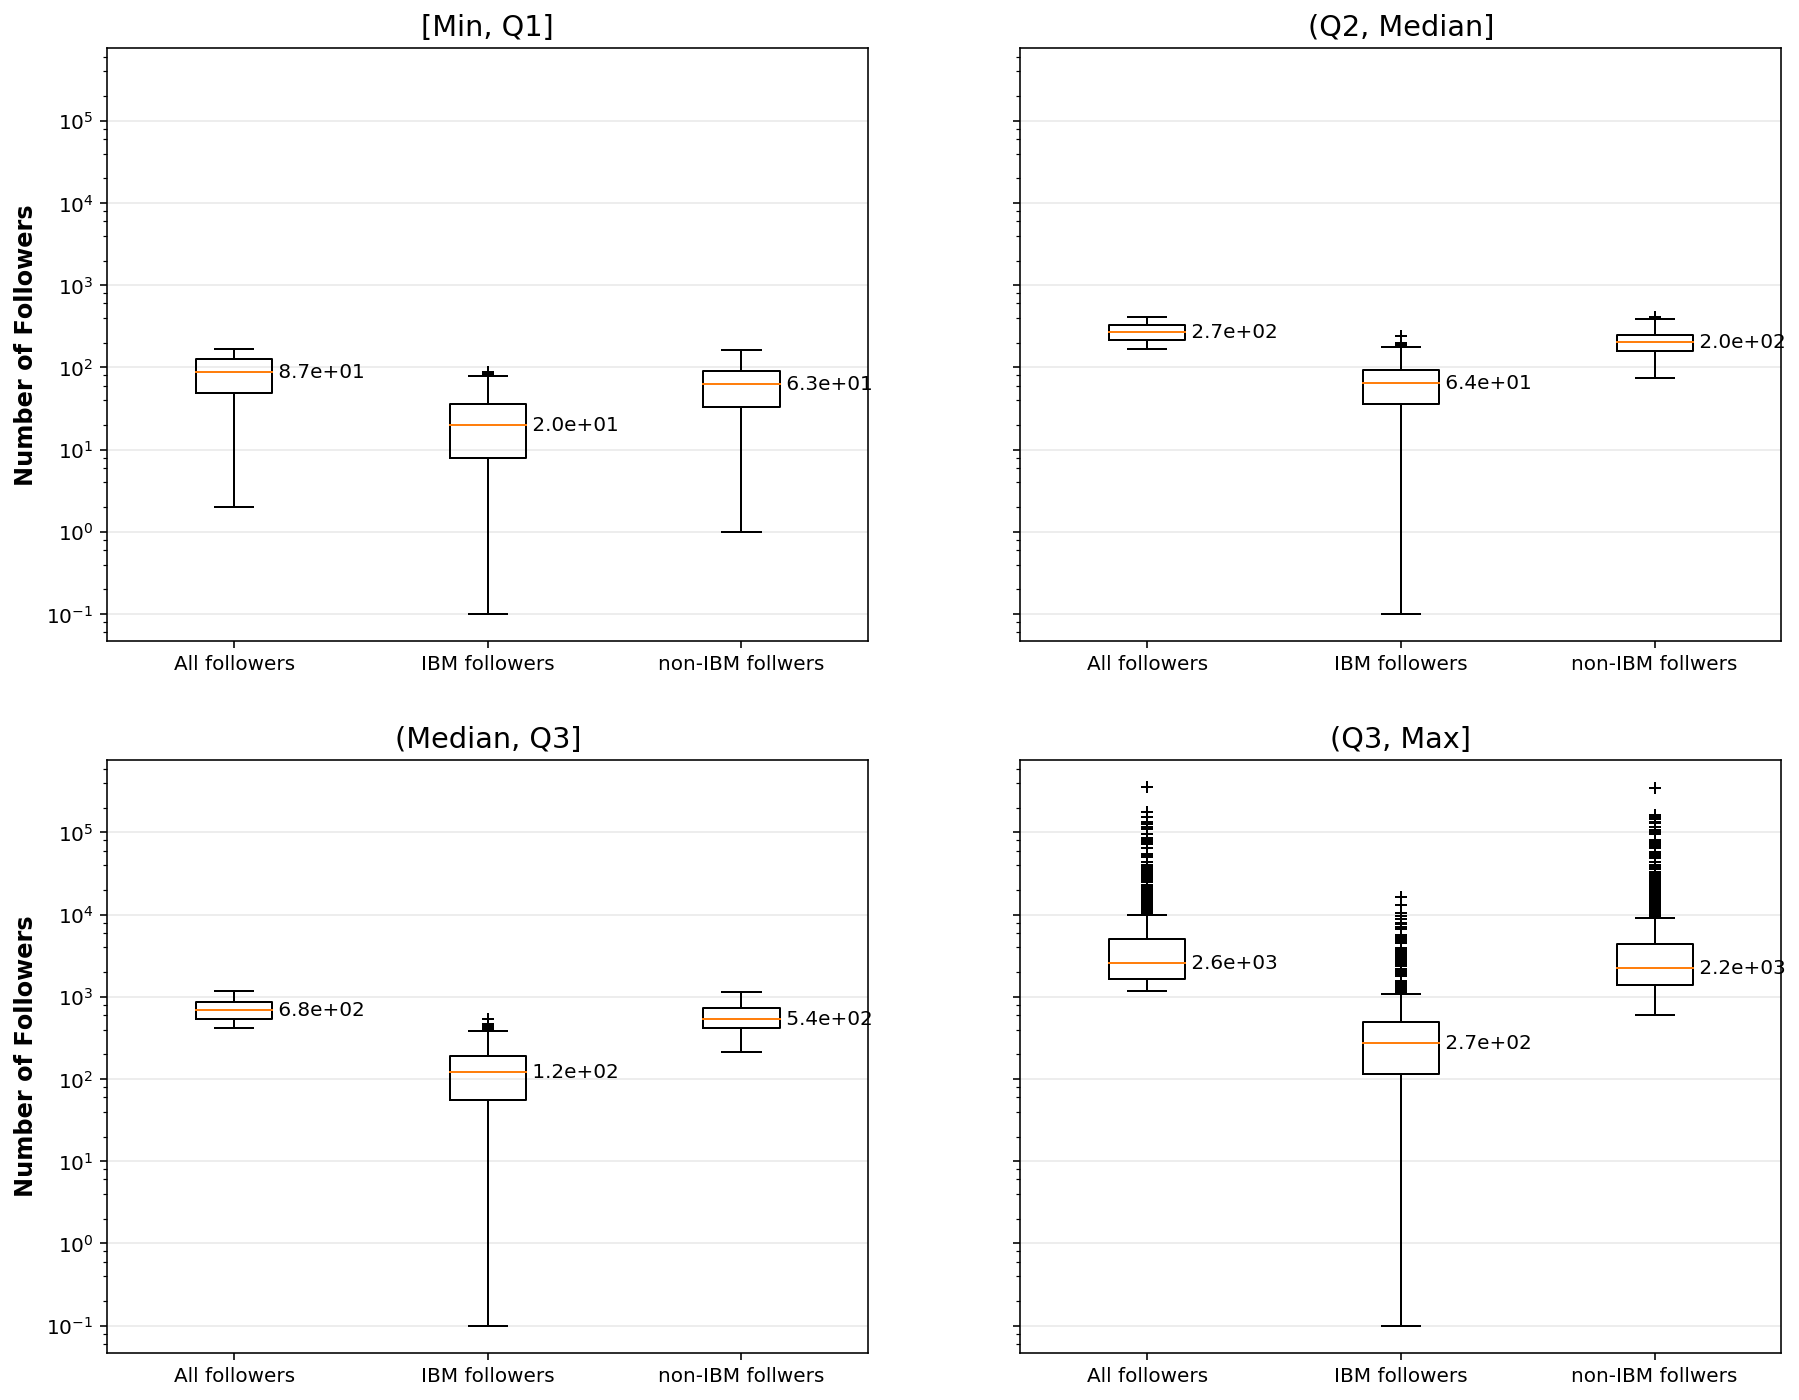

In [11]:
"""
Boxplots of total/IBM/non-IBM followers based on quartiles
"""
m1_ibm_popularity_levels_3_fig = os.path.join(FIG_DIR, 'm1_ibm_popularity_levels_3.png')
if 1 == 1:
    '''
    Prepare data
    '''
    # limit the minimal popularity level (clear 0 'fo_ibm' to avoid err in log scale)
    min_popularity_cond = (df['fo_ibm'] == 0)
    df.loc[min_popularity_cond, 'fo_ibm'] = 0.1

    data_lst = []
    for quartile in range(4):
        fo_all_quar = df[df['fo_2_quar'] == quartile]['fo_2']
        fo_ibm_quar = df[df['fo_2_quar'] == quartile]['fo_ibm']
        fo_nonibm_quar = df[df['fo_2_quar'] == quartile]['fo_nonibm'] 
        data_quar = [fo_all_quar, fo_ibm_quar, fo_nonibm_quar]
        data_lst.append(data_quar)
    
    '''
    Plot
    '''
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12), sharey=True)
    
    title_fontdict = {'size': 'x-large'}
    label_fontdict = {'weight': 'bold', 'size': 'large'}
    bp_lst = []
    # 1st quartile
    bp_1 = axes[0, 0].boxplot(data_lst[0], notch=False, sym='k+', vert=True)
    axes[0, 0].set_title('[Min, Q1]', fontdict=title_fontdict)
    axes[0, 0].set_ylabel('Number of Followers', fontdict=label_fontdict)
    bp_lst.append(bp_1)
    
    # 2nd quartile
    bp_2 = axes[0, 1].boxplot(data_lst[1], notch=False, sym='k+', vert=True)
    axes[0, 1].set_title('(Q2, Median]', fontdict=title_fontdict)
    bp_lst.append(bp_2)

    # 3rd quartile
    bp_3 = axes[1, 0].boxplot(data_lst[2], notch=False, sym='k+', vert=True)
    axes[1, 0].set_title('(Median, Q3]', fontdict=title_fontdict)
    axes[1, 0].set_ylabel('Number of Followers', fontdict=label_fontdict)
    bp_lst.append(bp_3)

    # 4th quartile
    bp_4 = axes[1, 1].boxplot(data_lst[3], notch=False, sym='k+', vert=True)
    axes[1, 1].set_title('(Q3, Max]', fontdict=title_fontdict)
    bp_lst.append(bp_4)
    
    # custom ax of each plot
    for _, ax in enumerate(axes.flatten()):
        ax.set_xticklabels(['All followers', 'IBM followers', 'non-IBM follwers'])
        
        # add a horizontal grid to the plot, but make it very light in color
        ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
        ax.set_axisbelow(True)
        
        # add median value text to the median line
        for line in bp_lst[_]['medians']:
            # get position data for median line
            x, y = line.get_xydata()[1] # right point of median line
            # overlay median value
            ax.text(x, y, '{:8.1e}'.format(y), horizontalalignment='left', verticalalignment='center')

        ax.set_yscale('log')
        #ax.set_yticklabels([])
    
#     plt.setp(bp['boxes'], color='black')
#     plt.setp(bp['whiskers'], color='black')
#     plt.setp(bp['fliers'], color='red', marker='+', markersize=5)

    suptitle_fontdict = {'weight': 'bold', 'size': 'x-large'}
    #fig.suptitle('Distribtuion of popularity levels', fontdict=suptitle_fontdict)
    fig.subplots_adjust(hspace=0.2)
    
    '''
    Save figure
    '''
    plt.savefig(m1_ibm_popularity_levels_3_fig, dpi=200)

## Check the distribution of followers_engagement levels of M1 IBM users
The follwers engagement level of a user is calculated as the average retweet_count over all native tweets

In [14]:
df.describe(np.arange(0.1, 1, 0.1))

,uid,fo,all_n,all_srt,ibm_n,ibm_srt,nonibm_n,nonibm_srt,fo_2,fo_ibm,native_n,fo_nonibm,fo_2_quar,all_simple_inf,in_simple_inf,out_simple_inf,all_compound_inf,in_compound_inf,out_compound_inf
count,3.708000e+03,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3.708000e+03,3.708000e+03,3.708000e+03,3708.000000,3708.000000,3708.000000
mean,5.060382e+16,2086.938781,7.495955,35.831446,3.880529,11.131607,6.029935,24.699838,2103.889428,194.118959,19.926645,1909.771845,1.498382,7.952375e-03,2.398495e-02,7.439521e-03,10.361020,2.723863,6.535513
std,1.919076e+17,10348.294746,24.609970,359.441014,17.151148,114.842189,22.060280,251.072907,10405.718706,640.664174,56.686660,9915.959737,1.119630,4.479740e-02,6.644348e-01,4.677205e-02,33.335735,8.289360,26.598623
min,1.142600e+04,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.100000,1.000000,1.000000,0.000000,7.006702e-07,1.000000e-07,1.000000e-07,0.064984,0.010000,0.010000
10%,1.842220e+07,66.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,71.000000,8.000000,1.000000,50.000000,0.000000,1.625583e-04,1.000000e-07,1.000000e-07,0.956760,0.010000,0.010000
20%,3.938379e+07,127.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,135.000000,19.000000,2.000000,95.000000,0.000000,3.745919e-04,1.000000e-07,8.334639e-05,1.606761,0.010000,0.492989
30.0%,9.229542e+07,196.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,206.100000,33.000000,3.000000,150.000000,1.000000,6.638275e-04,1.000000e-07,2.553486e-04,2.393918,0.010000,1.057568
40%,2.118461e+08,281.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,290.000000,49.000000,4.000000,220.000000,1.000000,1.061819e-03,2.889872e-04,5.045459e-04,3.262594,0.159292,1.675618
50%,3.700978e+08,403.000000,2.000000,4.000000,1.000000,1.000000,1.000000,2.000000,415.500000,69.000000,5.000000,317.000000,1.500000,1.608903e-03,1.098901e-03,9.456265e-04,4.481139,0.604262,2.446853
60%,5.688451e+08,590.200000,3.000000,5.000000,1.000000,2.000000,2.000000,3.000000,609.200000,96.000000,8.000000,489.000000,2.000000,2.534854e-03,2.422483e-03,1.602664e-03,5.737516,1.168207,3.459753


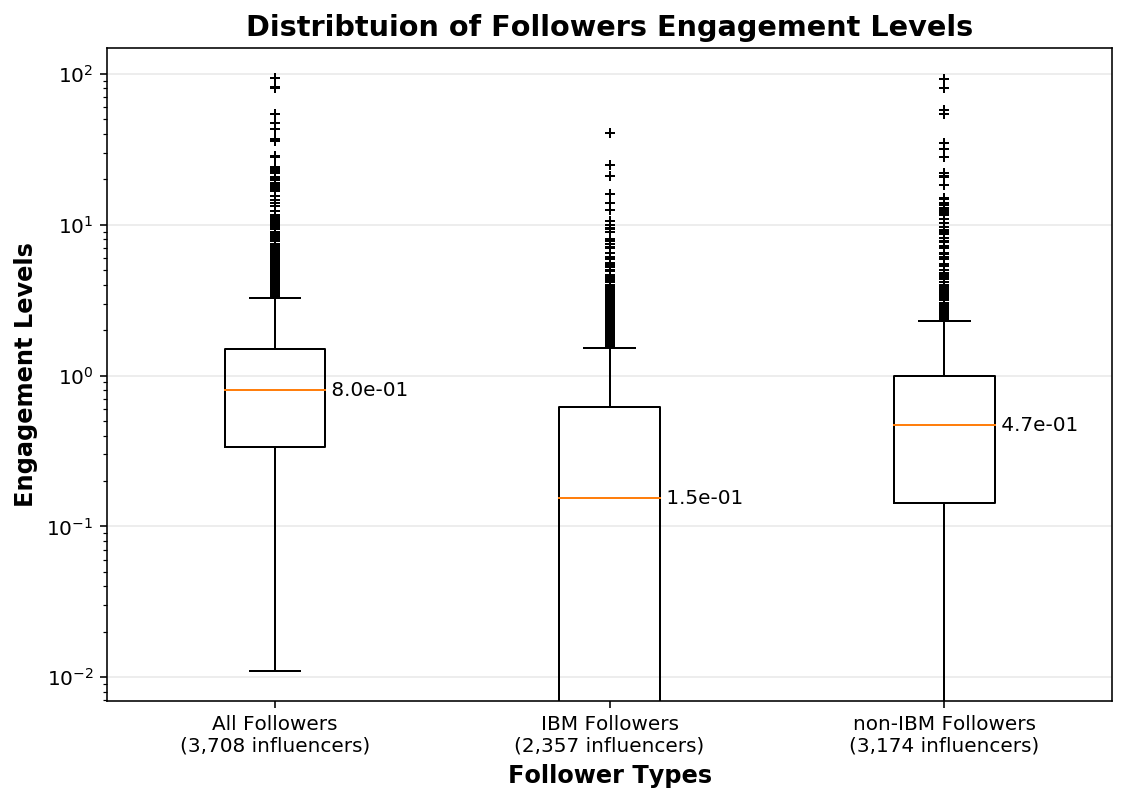

In [7]:
"""
Boxplot of average retweet_count by all/IBM/non-IBM followers
"""
m1_ibm_followers_engagement_levels_fig = os.path.join(FIG_DIR, 'm1_ibm_followers_engagement_levels.png')
if 1 == 1:
    '''
    Prepare data
    '''
    avg_rt_all = df['all_srt'] / df['native_n']
    avg_rt_ibm = df['ibm_srt'] / df['native_n']
    avg_rt_nonibm = df['nonibm_srt'] / df['native_n']
            
    data = [avg_rt_all, avg_rt_ibm, avg_rt_nonibm]
    
    '''
    Plot
    '''
    fig, ax = plt.subplots(figsize=(9, 6))
    
    bp = plt.boxplot(data, notch=False, sym='k+', vert=True)
    plt.setp(bp['boxes'], color='black')
    plt.setp(bp['whiskers'], color='black')
    plt.setp(bp['fliers'], color='red', marker='+', markersize=5)
    
    title_fontdict = {'weight': 'bold', 'size': 'x-large'}
    ax.set_title("Distribtuion of Followers Engagement Levels", fontdict=title_fontdict)
    
    label_fontdict = {'weight': 'bold', 'size': 'large'}
    ax.set_xlabel('Follower Types', fontdict=label_fontdict)
    ax.set_ylabel('Engagement Levels', fontdict=label_fontdict)
    ax.set_xticklabels(['All Followers\n({:,} influencers)'.format(avg_rt_all.shape[0]),
                        'IBM Followers\n({:,} influencers)'.format(df_in.shape[0]),
                        'non-IBM Followers\n({:,} influencers)'.format(df_out.shape[0])])
    ax.set_yscale('log')
    
    # add a horizontal grid to the plot, but make it very light in color
    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
    ax.set_axisbelow(True)
    
    # add median value text to the median line
    for line in bp['medians']:
        # get position data for median line
        x, y = line.get_xydata()[1] # right point of median line
        # overlay median value
        ax.text(x, y, '{:8.1e}'.format(y), horizontalalignment='left', verticalalignment='center')
    
    '''
    Save figure
    '''
    plt.savefig(m1_ibm_followers_engagement_levels_fig, dpi=200)

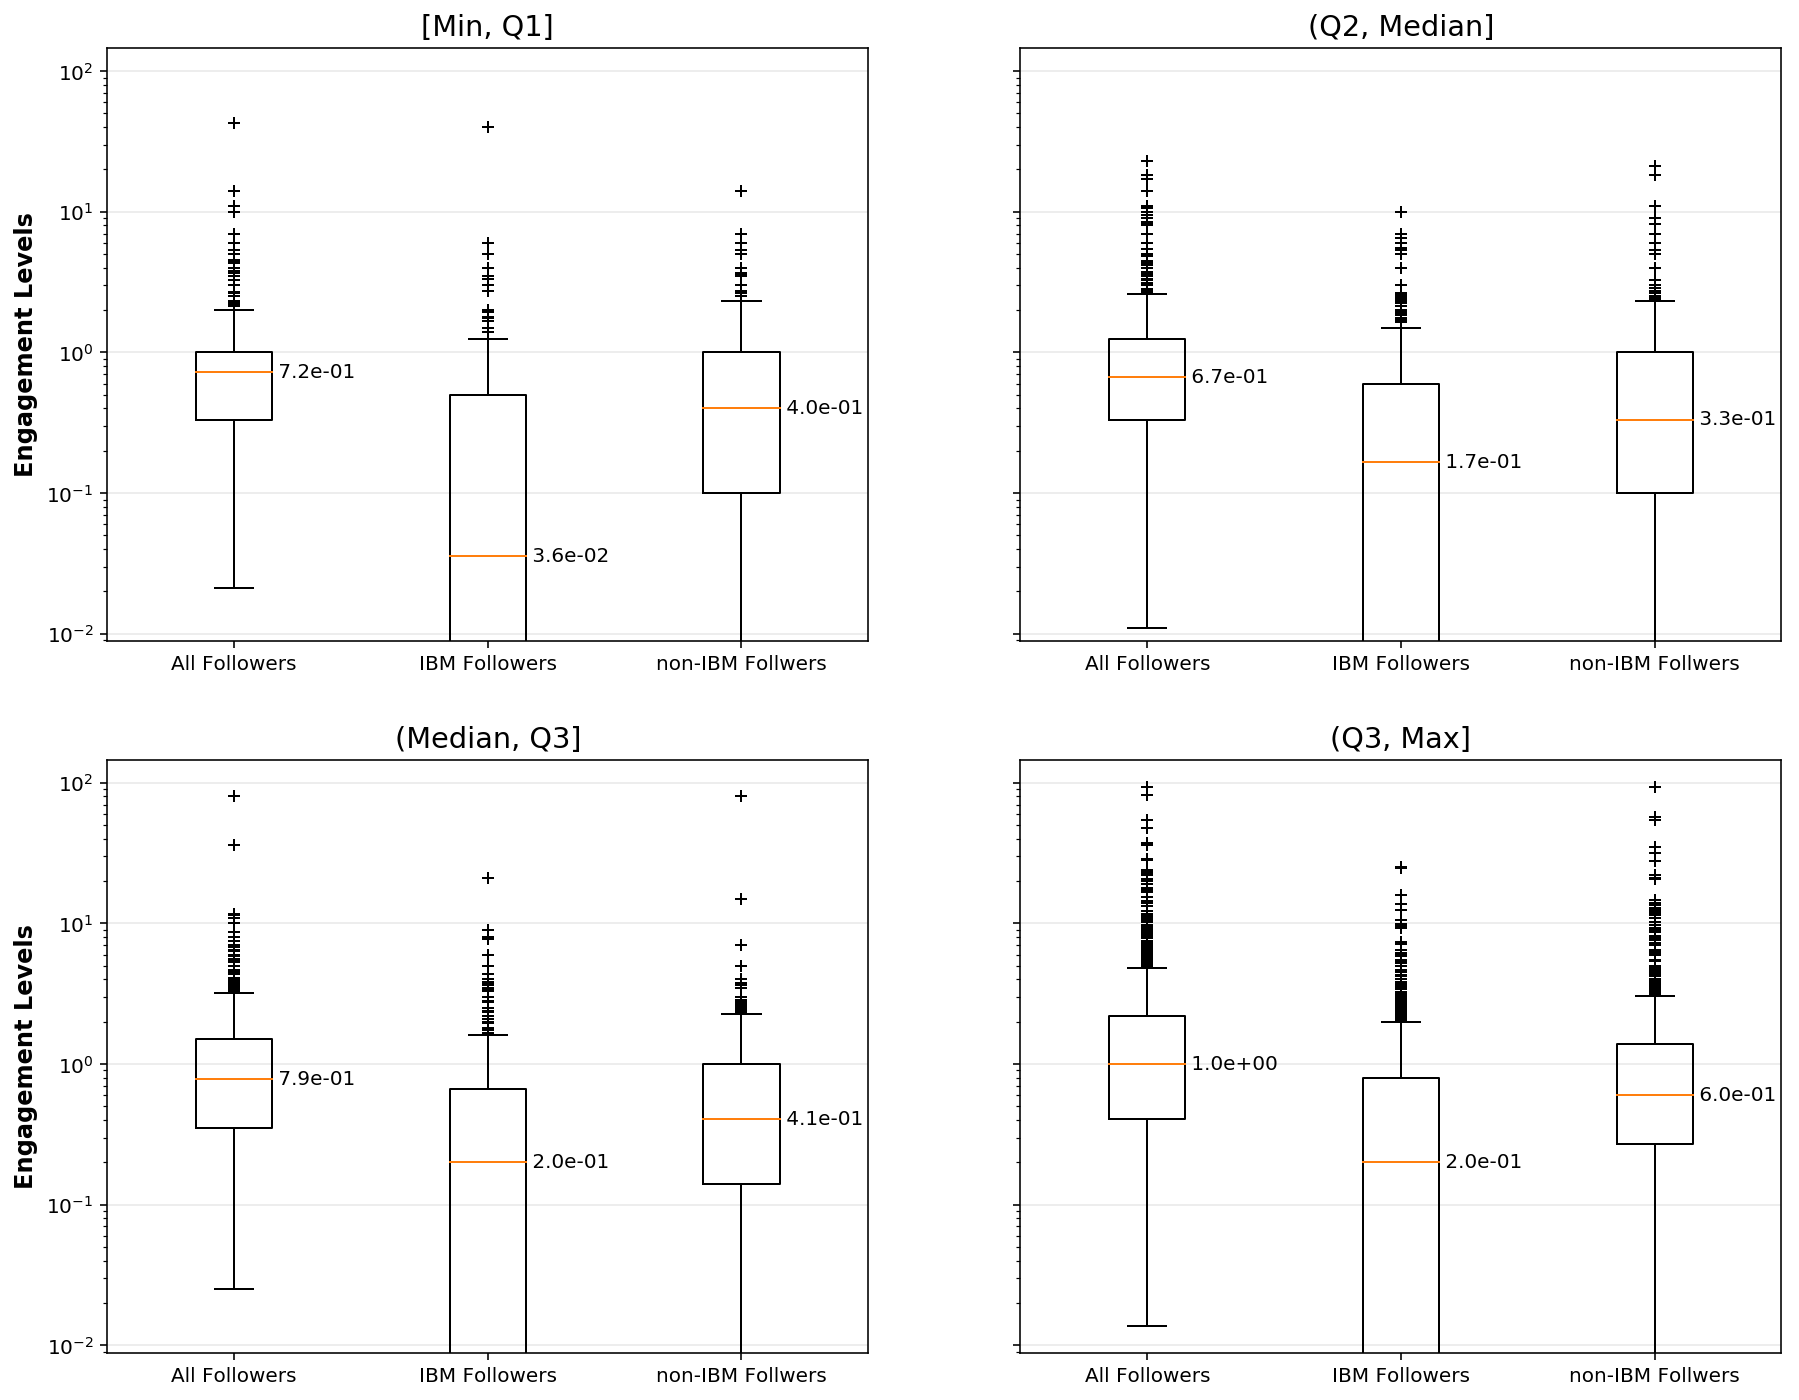

In [12]:
"""
Boxplots of average retweet_count by all/IBM/non-IBM followers in 4 quartiles
"""
m1_ibm_followers_engagement_levels_2_fig = os.path.join(FIG_DIR, 'm1_ibm_followers_engagement_levels_2.png')
if 1 == 1:
    '''
    Prepare data
    '''
    data_lst = []
    for quartile in range(4):
        quar_cond = (df['fo_2_quar'] == quartile)
        df_quar = df[quar_cond]
        avg_rt_all_quar = df_quar['all_srt'] / df_quar['native_n']
        avg_rt_ibm_quar = df_quar['ibm_srt'] / df_quar['native_n']
        avg_rt_nonibm_quar = df_quar['nonibm_srt'] / df_quar['native_n']
        
        data_quar = [avg_rt_all_quar, avg_rt_ibm_quar, avg_rt_nonibm_quar]
        data_lst.append(data_quar)
    
    '''
    Plot
    '''
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12), sharey=True)
    
    title_fontdict = {'size': 'x-large'}
    label_fontdict = {'weight': 'bold', 'size': 'large'}
    bp_lst = []
    # 1st quartile
    bp_1 = axes[0, 0].boxplot(data_lst[0], notch=False, sym='k+', vert=True)
    axes[0, 0].set_title('[Min, Q1]', fontdict=title_fontdict)
    axes[0, 0].set_ylabel('Engagement Levels', fontdict=label_fontdict)
    bp_lst.append(bp_1)
    
    # 2nd quartile
    bp_2 = axes[0, 1].boxplot(data_lst[1], notch=False, sym='k+', vert=True)
    axes[0, 1].set_title('(Q2, Median]', fontdict=title_fontdict)
    bp_lst.append(bp_2)

    # 3rd quartile
    bp_3 = axes[1, 0].boxplot(data_lst[2], notch=False, sym='k+', vert=True)
    axes[1, 0].set_title('(Median, Q3]', fontdict=title_fontdict)
    axes[1, 0].set_ylabel('Engagement Levels', fontdict=label_fontdict)
    bp_lst.append(bp_3)

    # 4th quartile
    bp_4 = axes[1, 1].boxplot(data_lst[3], notch=False, sym='k+', vert=True)
    axes[1, 1].set_title('(Q3, Max]', fontdict=title_fontdict)
    bp_lst.append(bp_4)
    
    # custom ax of each plot
    for _, ax in enumerate(axes.flatten()):
        ax.set_xticklabels(['All Followers', 'IBM Followers', 'non-IBM Follwers'])
        
        # add a horizontal grid to the plot, but make it very light in color
        ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
        ax.set_axisbelow(True)
        
        # add median value text to the median line
        for line in bp_lst[_]['medians']:
            # get position data for median line
            x, y = line.get_xydata()[1] # right point of median line
            # overlay median value
            ax.text(x, y, '{:8.1e}'.format(y), horizontalalignment='left', verticalalignment='center')

        ax.set_yscale('log')
        #ax.set_yticklabels([])
    
    plt.setp(bp['boxes'], color='black')
    plt.setp(bp['whiskers'], color='black')
    plt.setp(bp['fliers'], color='red', marker='+', markersize=5)

    suptitle_fontdict = {'weight': 'bold', 'size': 'x-large'}
    #fig.suptitle('Distribtuion of popularity levels', fontdict=suptitle_fontdict)
    fig.subplots_adjust(hspace=0.2)
    
    '''
    Save figure
    '''
    plt.savefig(m1_ibm_followers_engagement_levels_2_fig, dpi=200)

In [17]:
df.describe()

,uid,fo,all_n,all_srt,ibm_n,ibm_srt,nonibm_n,nonibm_srt,fo_2,fo_ibm,native_n,fo_nonibm,fo_2_quar,all_simple_inf,in_simple_inf,out_simple_inf,all_compound_inf,in_compound_inf,out_compound_inf
count,3.708000e+03,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3.708000e+03,3.708000e+03,3.708000e+03,3708.000000,3708.000000,3708.000000
mean,5.060382e+16,2086.938781,7.495955,35.831446,3.880529,11.131607,6.029935,24.699838,2103.889428,194.118959,19.926645,1909.771845,1.498382,7.952375e-03,2.398495e-02,7.439521e-03,10.361020,2.723863,6.535513
std,1.919076e+17,10348.294746,24.609970,359.441014,17.151148,114.842189,22.060280,251.072907,10405.718706,640.664174,56.686660,9915.959737,1.119630,4.479740e-02,6.644348e-01,4.677205e-02,33.335735,8.289360,26.598623
min,1.142600e+04,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.100000,1.000000,1.000000,0.000000,7.006702e-07,1.000000e-07,1.000000e-07,0.064984,0.010000,0.010000
25%,5.874478e+07,159.750000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,167.000000,26.000000,2.000000,123.000000,0.000000,4.987603e-04,1.000000e-07,1.577005e-04,2.017726,0.010000,0.793314
50%,3.700978e+08,403.000000,2.000000,4.000000,1.000000,1.000000,1.000000,2.000000,415.500000,69.000000,5.000000,317.000000,1.500000,1.608903e-03,1.098901e-03,9.456265e-04,4.481139,0.604262,2.446853
75%,2.204183e+09,1140.250000,5.000000,10.000000,2.000000,3.000000,4.000000,6.000000,1167.250000,165.000000,17.000000,991.000000,2.250000,5.144198e-03,6.756757e-03,3.703704e-03,9.100423,2.707234,5.737077
max,8.623589e+17,360556.000000,428.000000,14497.000000,333.000000,4877.000000,426.000000,9620.000000,362337.000000,16223.000000,1330.000000,346114.000000,3.000000,1.791667e+00,4.025000e+01,2.000000e+00,1052.376124,239.817227,795.789550


## Simple influence by different (user_popularity, followers_engagement) combinations

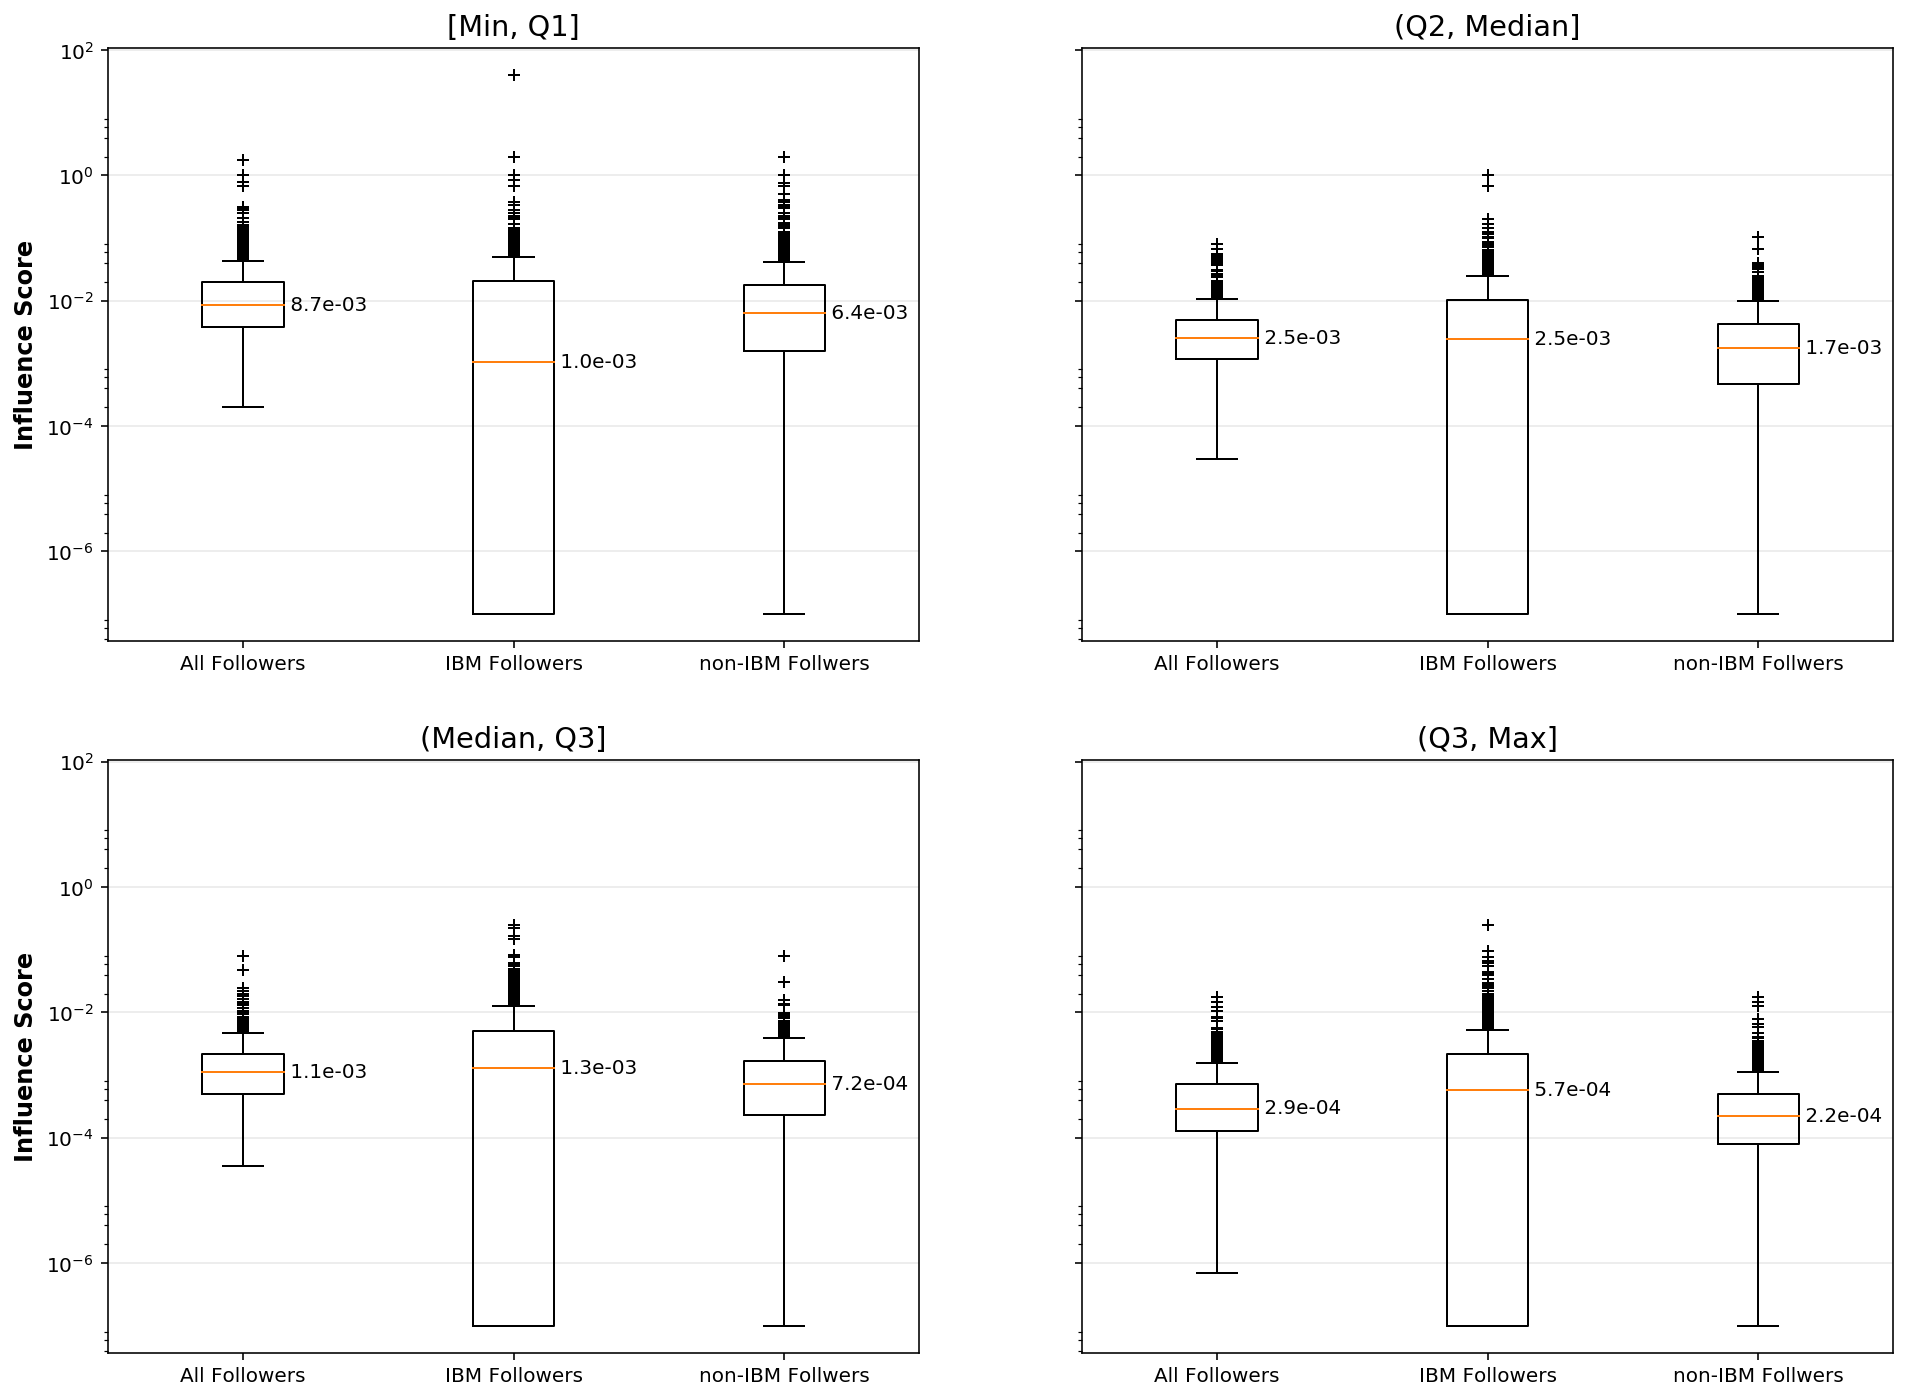

In [13]:
"""
Boxplots of simple influence of M1 IBM users inside/outside IBM in 4 quartiles
"""
ibm_simple_influence_in_out_2_fig = os.path.join(FIG_DIR, 'ibm_simple_influence_in_out_2.png')
if 1 == 1:
    '''
    Prepare data
    '''
    data_lst = []
    for quartile in range(4):     
        quar_cond = (df['fo_2_quar'] == quartile)
        df_quar = df[quar_cond]
        # IBM users' influence to all users
        all_simple_inf = df_quar['all_simple_inf']
        # IBM users' influence to IBM users (inside)
        in_simple_inf = df_quar['in_simple_inf']
        # IBM users' influence to non-IBM users (outside)
        out_simple_inf = df_quar['out_simple_inf']

        data_quar = [all_simple_inf, in_simple_inf, out_simple_inf]
        data_lst.append(data_quar)
    
    '''
    Plot
    '''
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12), sharey=True)
    
    title_fontdict = {'size': 'x-large'}
    label_fontdict = {'weight': 'bold', 'size': 'large'}
    bp_lst = []
    # 1st quartile
    bp_1 = axes[0, 0].boxplot(data_lst[0], notch=False, sym='k+', vert=True)
    axes[0, 0].set_title('[Min, Q1]', fontdict=title_fontdict)
    axes[0, 0].set_ylabel('Influence Score', fontdict=label_fontdict)
    bp_lst.append(bp_1)
    
    # 2nd quartile
    bp_2 = axes[0, 1].boxplot(data_lst[1], notch=False, sym='k+', vert=True)
    axes[0, 1].set_title('(Q2, Median]', fontdict=title_fontdict)
    bp_lst.append(bp_2)

    # 3rd quartile
    bp_3 = axes[1, 0].boxplot(data_lst[2], notch=False, sym='k+', vert=True)
    axes[1, 0].set_title('(Median, Q3]', fontdict=title_fontdict)
    axes[1, 0].set_ylabel('Influence Score', fontdict=label_fontdict)
    bp_lst.append(bp_3)

    # 4th quartile
    bp_4 = axes[1, 1].boxplot(data_lst[3], notch=False, sym='k+', vert=True)
    axes[1, 1].set_title('(Q3, Max]', fontdict=title_fontdict)
    bp_lst.append(bp_4)
    
    # custom ax of each plot
    for _, ax in enumerate(axes.flatten()):
        ax.set_xticklabels(['All Followers', 'IBM Followers', 'non-IBM Follwers'])
        
        # add a horizontal grid to the plot, but make it very light in color
        ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
        ax.set_axisbelow(True)
        
        # add median value text to the median line
        for line in bp_lst[_]['medians']:
            # get position data for median line
            x, y = line.get_xydata()[1] # right point of median line
            # overlay median value
            ax.text(x, y, '{:8.1e}'.format(y), horizontalalignment='left', verticalalignment='center')

        ax.set_yscale('log')
        #ax.set_yticklabels([])
    
    plt.setp(bp['boxes'], color='black')
    plt.setp(bp['whiskers'], color='black')
    plt.setp(bp['fliers'], color='red', marker='+', markersize=5)

    suptitle_fontdict = {'weight': 'bold', 'size': 'x-large'}
    #fig.suptitle('Distribtuion of popularity levels', fontdict=suptitle_fontdict)
    fig.subplots_adjust(hspace=0.2)
    
    '''
    Save figure
    '''
    plt.savefig(ibm_simple_influence_in_out_2_fig, dpi=200)

In [9]:
df.describe()

,uid,fo,all_n,all_srt,ibm_n,ibm_srt,nonibm_n,nonibm_srt,fo_2,fo_ibm,native_n,fo_nonibm,fo_2_quar,all_simple_inf,in_simple_inf,out_simple_inf,all_compound_inf,in_compound_inf,out_compound_inf
count,3.708000e+03,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3.708000e+03,3.708000e+03,3.708000e+03,3708.000000,3708.000000,3708.000000
mean,5.060382e+16,2086.938781,7.495955,35.831446,3.880529,11.131607,6.029935,24.699838,2103.889428,194.118959,19.926645,1909.771845,1.498382,7.952375e-03,2.398495e-02,7.439521e-03,10.361020,2.723863,6.535513
std,1.919076e+17,10348.294746,24.609970,359.441014,17.151148,114.842189,22.060280,251.072907,10405.718706,640.664174,56.686660,9915.959737,1.119630,4.479740e-02,6.644348e-01,4.677205e-02,33.335735,8.289360,26.598623
min,1.142600e+04,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.100000,1.000000,1.000000,0.000000,7.006702e-07,1.000000e-07,1.000000e-07,0.064984,0.010000,0.010000
25%,5.874478e+07,159.750000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,167.000000,26.000000,2.000000,123.000000,0.000000,4.987603e-04,1.000000e-07,1.577005e-04,2.017726,0.010000,0.793314
50%,3.700978e+08,403.000000,2.000000,4.000000,1.000000,1.000000,1.000000,2.000000,415.500000,69.000000,5.000000,317.000000,1.500000,1.608903e-03,1.098901e-03,9.456265e-04,4.481139,0.604262,2.446853
75%,2.204183e+09,1140.250000,5.000000,10.000000,2.000000,3.000000,4.000000,6.000000,1167.250000,165.000000,17.000000,991.000000,2.250000,5.144198e-03,6.756757e-03,3.703704e-03,9.100423,2.707234,5.737077
max,8.623589e+17,360556.000000,428.000000,14497.000000,333.000000,4877.000000,426.000000,9620.000000,362337.000000,16223.000000,1330.000000,346114.000000,3.000000,1.791667e+00,4.025000e+01,2.000000e+00,1052.376124,239.817227,795.789550


## Compound inlfuence by different (user_popularity, followers_engagement) combinations

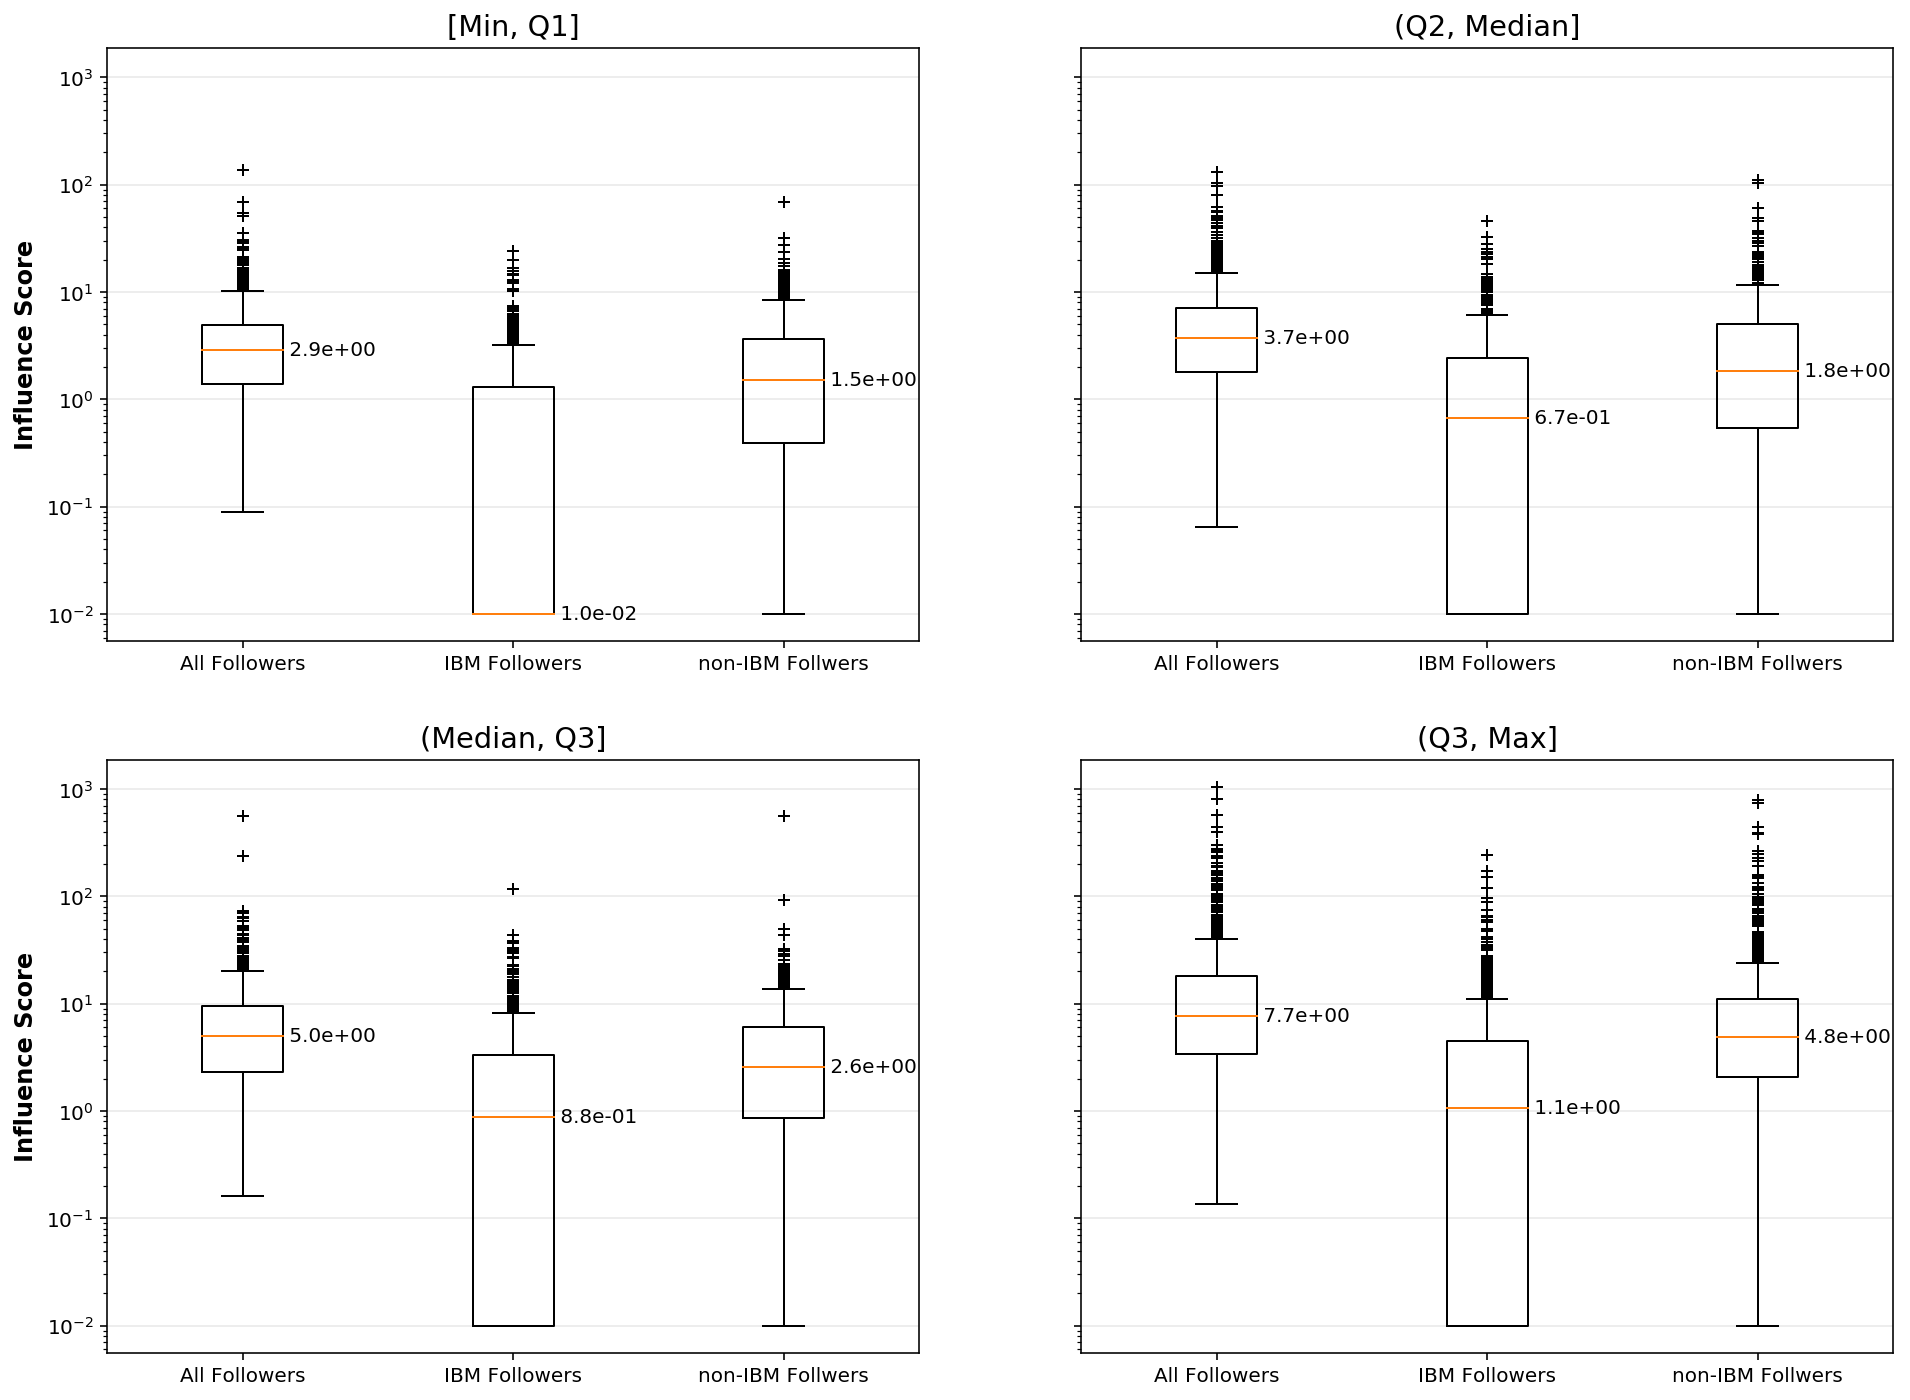

In [14]:
"""
Boxplots of compound influence of M1 IBM users inside/outside IBM in 4 quartiles
"""
ibm_compound_influence_in_out_2_fig = os.path.join(FIG_DIR, 'ibm_compound_influence_in_out_2.png')
if 1 == 1:
    '''
    Prepare data
    '''
    data_lst = []
    for quartile in range(4):     
        quar_cond = (df['fo_2_quar'] == quartile)
        df_quar = df[quar_cond]
        # IBM users' influence to all users
        all_simple_inf = df_quar['all_compound_inf']
        # IBM users' influence to IBM users (inside)
        in_simple_inf = df_quar['in_compound_inf']
        # IBM users' influence to non-IBM users (outside)
        out_simple_inf = df_quar['out_compound_inf']

        data_quar = [all_simple_inf, in_simple_inf, out_simple_inf]
        data_lst.append(data_quar)
    
    '''
    Plot
    '''
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12), sharey=True)
    
    title_fontdict = {'size': 'x-large'}
    label_fontdict = {'weight': 'bold', 'size': 'large'}
    bp_lst = []
    # 1st quartile
    bp_1 = axes[0, 0].boxplot(data_lst[0], notch=False, sym='k+', vert=True)
    axes[0, 0].set_title('[Min, Q1]', fontdict=title_fontdict)
    axes[0, 0].set_ylabel('Influence Score', fontdict=label_fontdict)
    bp_lst.append(bp_1)
    
    # 2nd quartile
    bp_2 = axes[0, 1].boxplot(data_lst[1], notch=False, sym='k+', vert=True)
    axes[0, 1].set_title('(Q2, Median]', fontdict=title_fontdict)
    bp_lst.append(bp_2)

    # 3rd quartile
    bp_3 = axes[1, 0].boxplot(data_lst[2], notch=False, sym='k+', vert=True)
    axes[1, 0].set_title('(Median, Q3]', fontdict=title_fontdict)
    axes[1, 0].set_ylabel('Influence Score', fontdict=label_fontdict)
    bp_lst.append(bp_3)

    # 4th quartile
    bp_4 = axes[1, 1].boxplot(data_lst[3], notch=False, sym='k+', vert=True)
    axes[1, 1].set_title('(Q3, Max]', fontdict=title_fontdict)
    bp_lst.append(bp_4)
    
    # custom ax of each plot
    for _, ax in enumerate(axes.flatten()):
        ax.set_xticklabels(['All Followers', 'IBM Followers', 'non-IBM Follwers'])
        
        # add a horizontal grid to the plot, but make it very light in color
        ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
        ax.set_axisbelow(True)
        
        # add median value text to the median line
        for line in bp_lst[_]['medians']:
            # get position data for median line
            x, y = line.get_xydata()[1] # right point of median line
            # overlay median value
            ax.text(x, y, '{:8.1e}'.format(y), horizontalalignment='left', verticalalignment='center')

        ax.set_yscale('log')
        #ax.set_yticklabels([])
    
    plt.setp(bp['boxes'], color='black')
    plt.setp(bp['whiskers'], color='black')
    plt.setp(bp['fliers'], color='red', marker='+', markersize=5)

    suptitle_fontdict = {'weight': 'bold', 'size': 'x-large'}
    #fig.suptitle('Distribtuion of popularity levels', fontdict=suptitle_fontdict)
    fig.subplots_adjust(hspace=0.2)
    
    '''
    Save figure
    '''
    plt.savefig(ibm_compound_influence_in_out_2_fig, dpi=200)